Read data

In [66]:

import pandas as pd
file_path = 'pip install pandas'
data = pd.read_csv('file:///Users/yujin/Downloads/booking.csv')
data_copy = data.copy()

Load necessary libraries

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import statistics as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
import numpy as np
from math import sqrt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, log_loss, confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# EDA and Data Cleaning
1/ boxplots for each variable

2/ correlation matrix

3/ variable encoding for indicator variables (including response variable, canceled = 1)

Notes:
1. Some reservations are showing with a booking date of 02/29/2018, which is a non-existent date. So this is being updated to 3/1/2018


['Booking_ID', 'number of adults', 'number of children', 'number of weekend nights', 'number of week nights', 'type of meal', 'car parking space', 'room type', 'lead time', 'market segment type', 'repeated', 'P-C', 'P-not-C', 'average price', 'special requests', 'date of reservation', 'booking status']


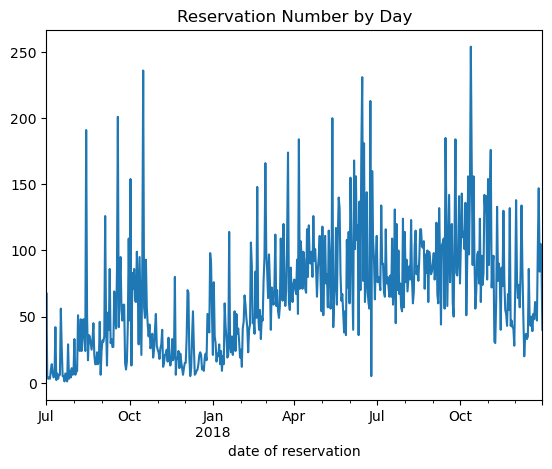

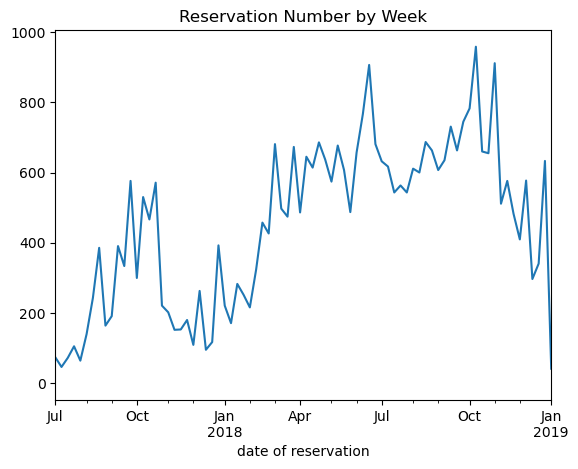

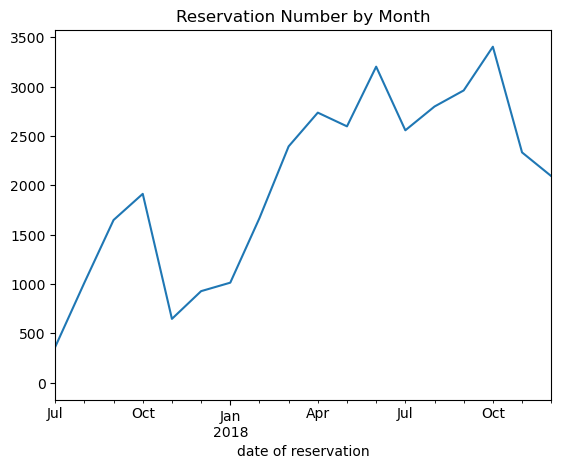

In [68]:
# columns in dataframe
print(data_copy.columns.tolist())

# reservations over time
date = 'date of reservation'
data_copy[date] = data_copy[date].astype(str).replace('2018-2-29', '2018-03-01')

data_copy[date] = pd.to_datetime(data_copy[date], errors='coerce')

# by Day
data_copy.set_index(date, inplace=True)
time_series = data_copy.resample('D').size()
plt.figure()
time_series.plot()
plt.xlim("2017-07-01", "2018-12-31")
plt.title("Reservation Number by Day")
plt.show()

# by Week
time_series = data_copy.resample('W').size()
plt.figure()
time_series.plot()
plt.xlim("2017-07-01", "2018-12-31")
plt.title("Reservation Number by Week")
plt.show()

# by Month
time_series = data_copy.resample('M').size()
plt.figure()
time_series.plot()
plt.xlim("2017-07-01", "2018-12-31")
plt.title("Reservation Number by Month")
plt.show()
data_copy.reset_index(inplace=True)

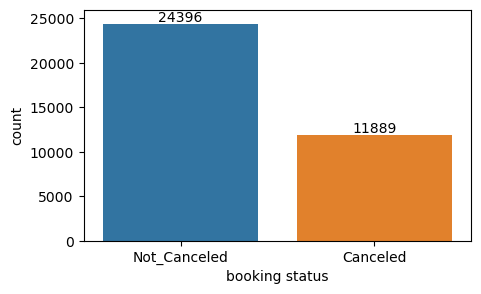

In [69]:
# counts of canceled vs not canceled
plt.figure(figsize=(5,3))
sns.countplot(data=data, x='booking status')

patches = plt.gca().patches
for patch in patches:
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 700, f'{int(height)}',
             ha='center', va='center')

plt.ylim(0, 26000)
plt.show()

In [70]:
# data prep
# data.drop(['Booking_ID', 'date of reservation'], axis=1, inplace=True)
# encoding indicator variables
indicator = ['type of meal', 'room type', 'market segment type']
indicators = pd.get_dummies(data[indicator])
data = data.drop(indicator, axis=1)
data = pd.concat([data, indicators], axis=1)

In [71]:
print(data.columns.tolist())

['Booking_ID', 'number of adults', 'number of children', 'number of weekend nights', 'number of week nights', 'car parking space', 'lead time', 'repeated', 'P-C', 'P-not-C', 'average price', 'special requests', 'date of reservation', 'booking status', 'type of meal_Meal Plan 1', 'type of meal_Meal Plan 2', 'type of meal_Meal Plan 3', 'type of meal_Not Selected', 'room type_Room_Type 1', 'room type_Room_Type 2', 'room type_Room_Type 3', 'room type_Room_Type 4', 'room type_Room_Type 5', 'room type_Room_Type 6', 'room type_Room_Type 7', 'market segment type_Aviation', 'market segment type_Complementary', 'market segment type_Corporate', 'market segment type_Offline', 'market segment type_Online']


In [72]:
data['Canceled'] = data['booking status'].map({'Canceled': 1, 'Not_Canceled': 0})
data.drop(['booking status', 'Booking_ID', 'date of reservation'], axis=1, inplace=True)
print(data.columns.tolist())
X = data.drop('Canceled', axis=1)
variables = X.columns.tolist()
y = data['Canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=122)

['number of adults', 'number of children', 'number of weekend nights', 'number of week nights', 'car parking space', 'lead time', 'repeated', 'P-C', 'P-not-C', 'average price', 'special requests', 'type of meal_Meal Plan 1', 'type of meal_Meal Plan 2', 'type of meal_Meal Plan 3', 'type of meal_Not Selected', 'room type_Room_Type 1', 'room type_Room_Type 2', 'room type_Room_Type 3', 'room type_Room_Type 4', 'room type_Room_Type 5', 'room type_Room_Type 6', 'room type_Room_Type 7', 'market segment type_Aviation', 'market segment type_Complementary', 'market segment type_Corporate', 'market segment type_Offline', 'market segment type_Online', 'Canceled']


In [73]:
X.columns

Index(['number of adults', 'number of children', 'number of weekend nights',
       'number of week nights', 'car parking space', 'lead time', 'repeated',
       'P-C', 'P-not-C', 'average price', 'special requests',
       'type of meal_Meal Plan 1', 'type of meal_Meal Plan 2',
       'type of meal_Meal Plan 3', 'type of meal_Not Selected',
       'room type_Room_Type 1', 'room type_Room_Type 2',
       'room type_Room_Type 3', 'room type_Room_Type 4',
       'room type_Room_Type 5', 'room type_Room_Type 6',
       'room type_Room_Type 7', 'market segment type_Aviation',
       'market segment type_Complementary', 'market segment type_Corporate',
       'market segment type_Offline', 'market segment type_Online'],
      dtype='object')

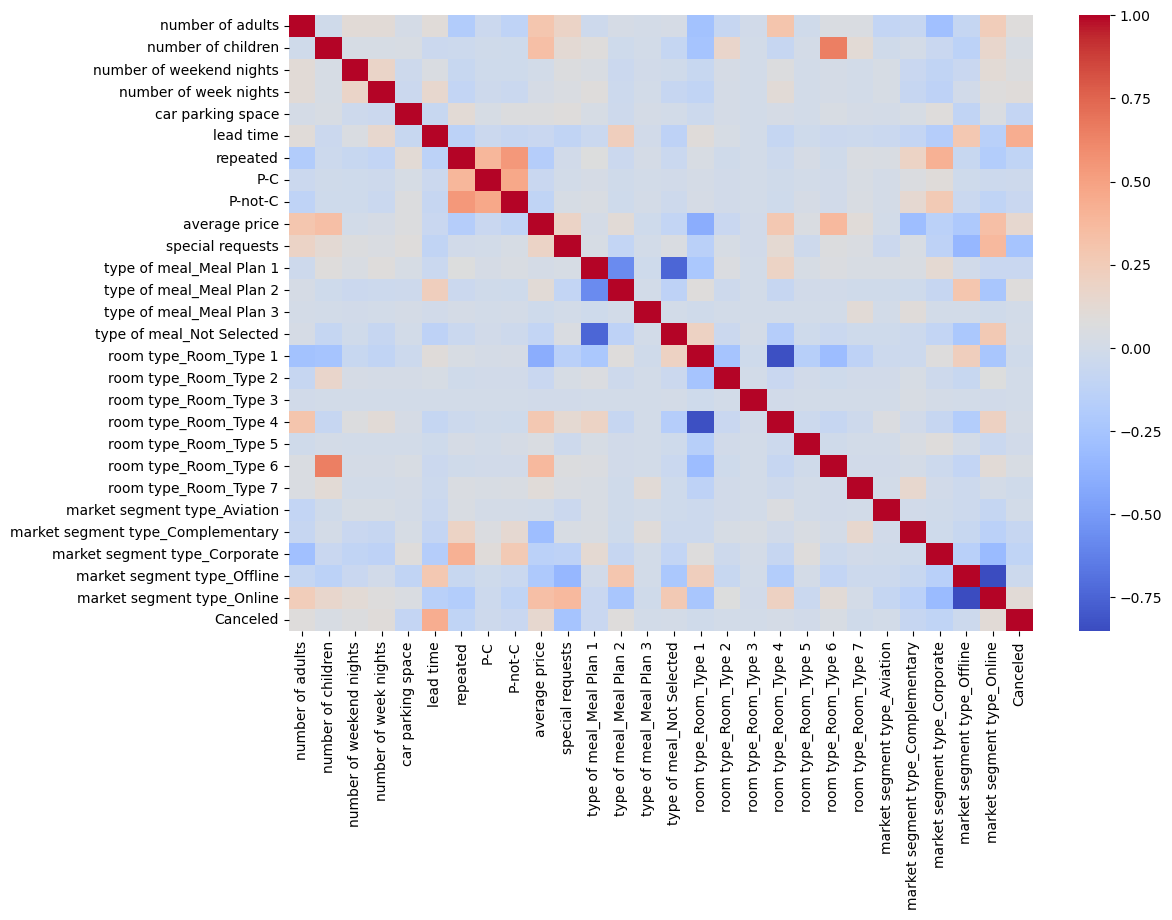

Features that are correlated include obvious ones, like previously-not-canceled and previously-canceled bookings, and repeated bookings. Number of children seems to be correlated with hotel room type 6.
Additionally, average room price and room type are moderately correlated. Looking at our response variable, whether a booking was canceled or not, we see some stronger correlations with special requests, lead time, and average price.


In [74]:
# correlation matrix
correlation = data.corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlation, annot=False, cmap='coolwarm')
plt.show()

print("Features that are correlated include obvious ones, like previously-not-canceled and previously-canceled bookings, and repeated bookings. Number of children seems to be correlated with hotel room type 6.")
print("Additionally, average room price and room type are moderately correlated. Looking at our response variable, whether a booking was canceled or not, we see some stronger correlations with special requests, lead time, and average price.")

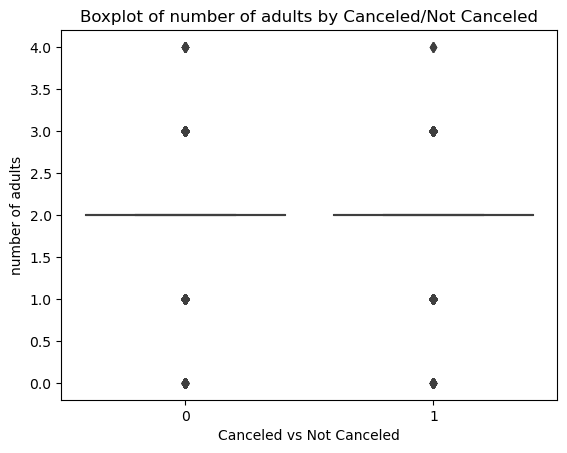

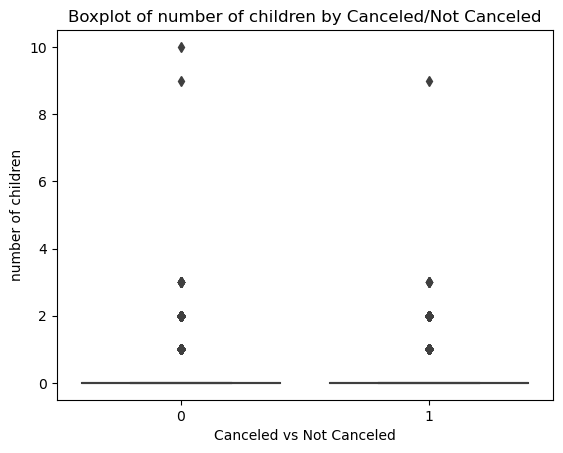

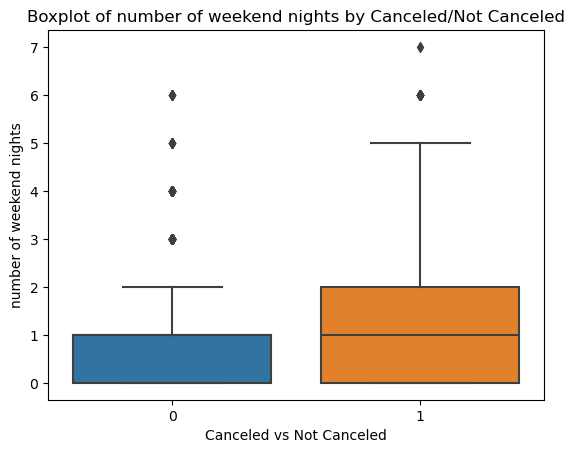

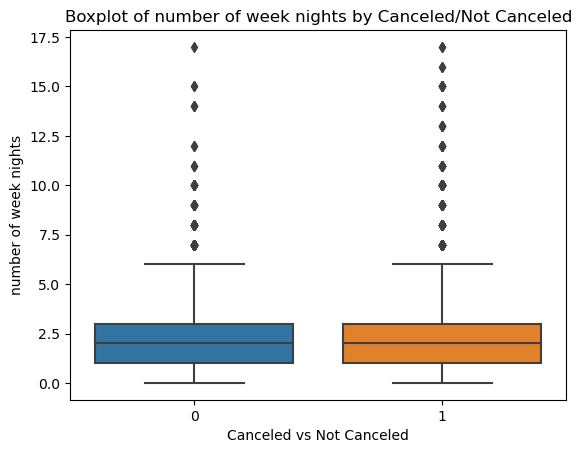

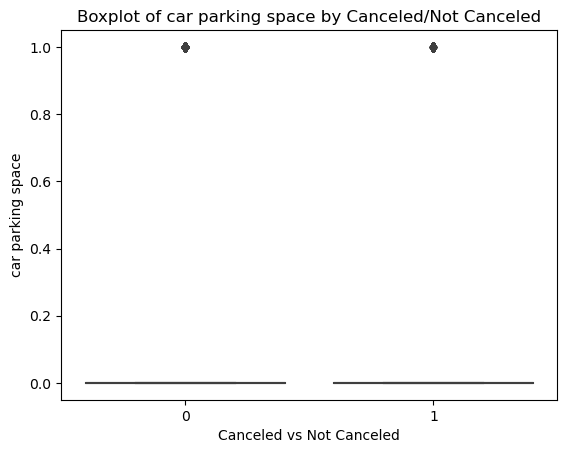

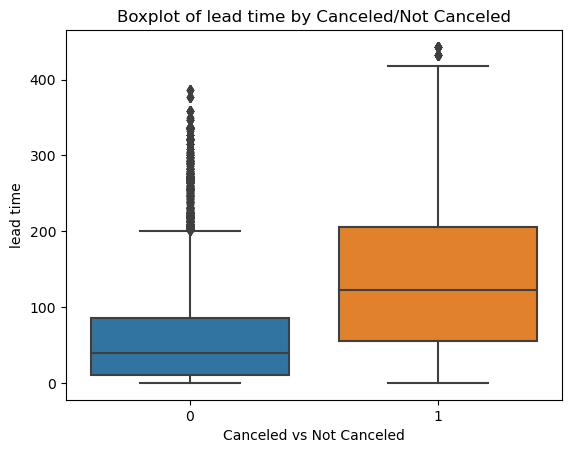

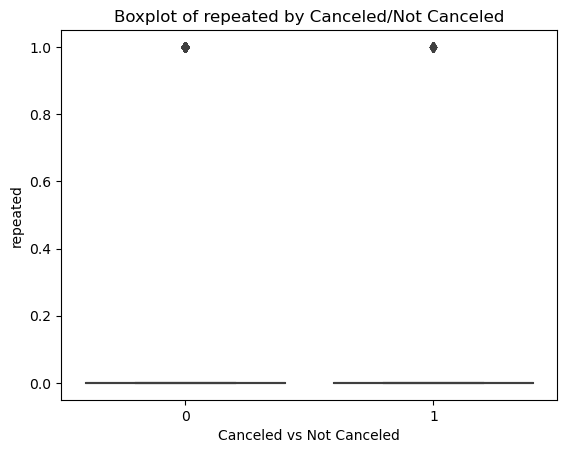

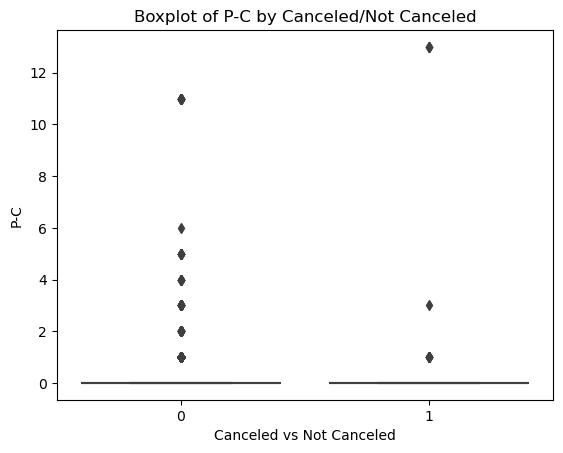

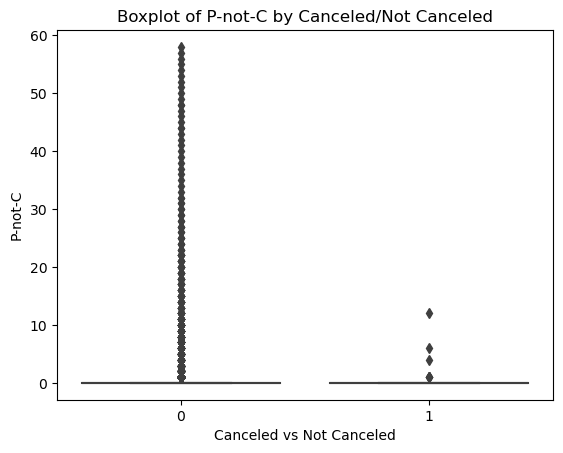

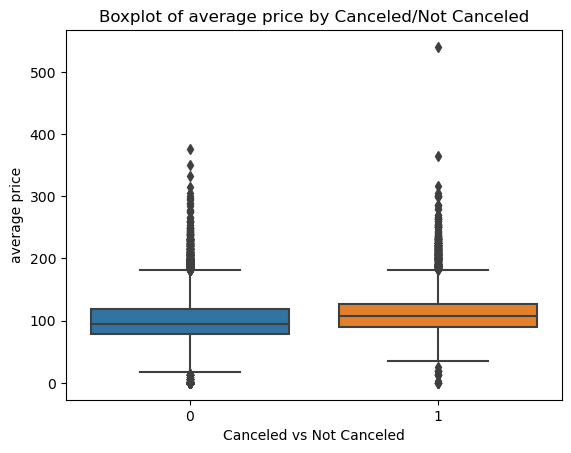

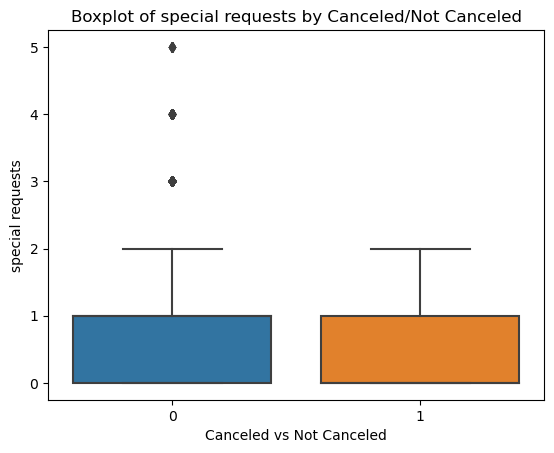

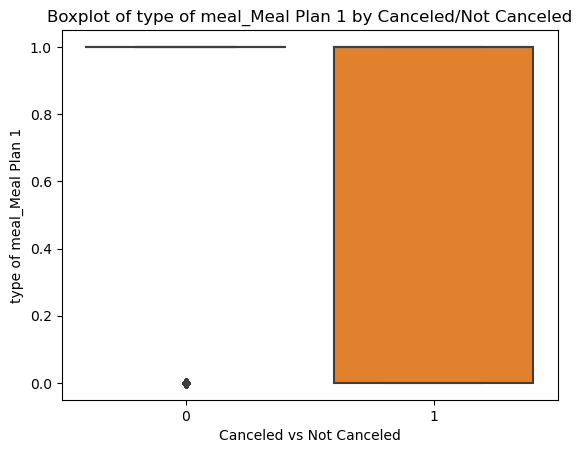

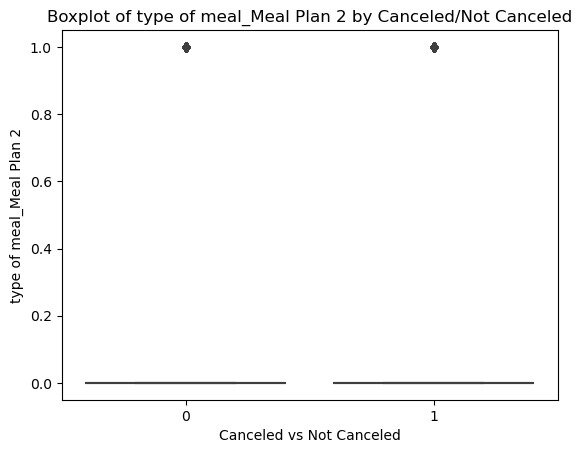

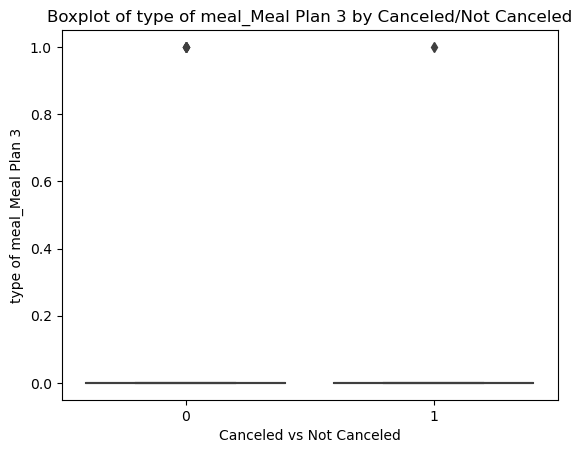

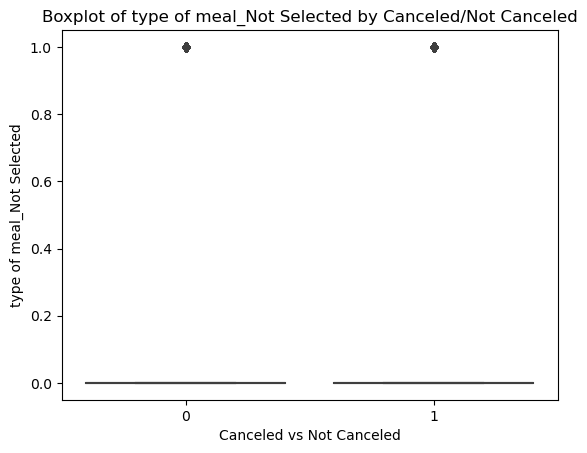

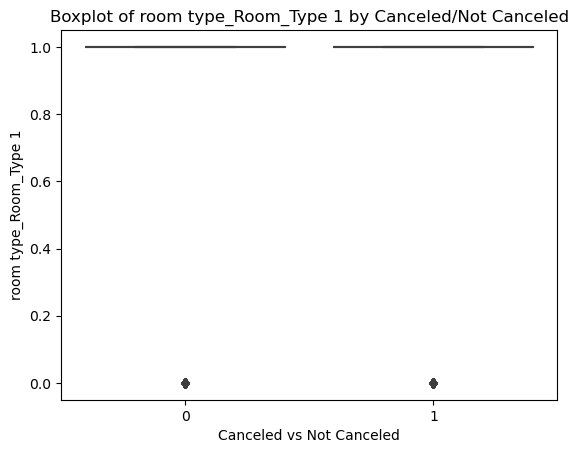

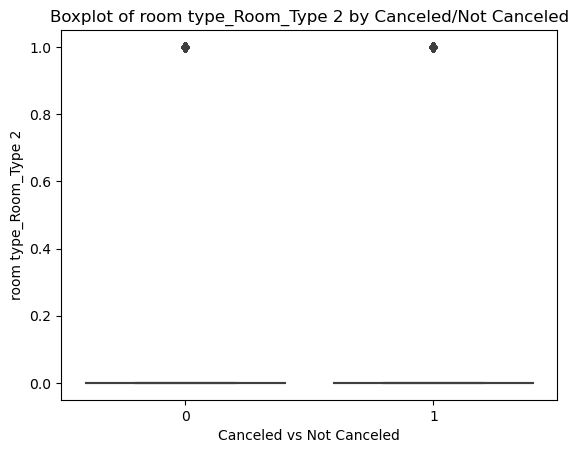

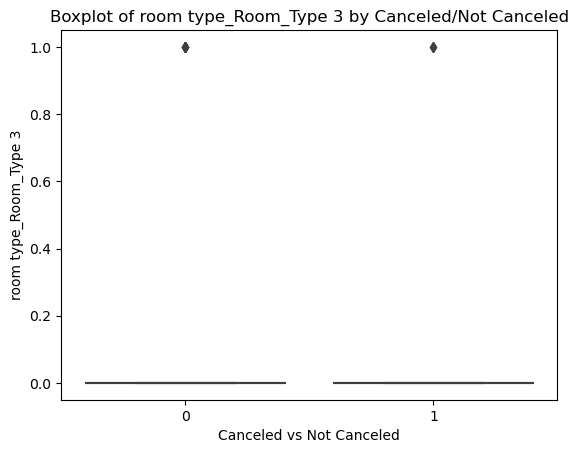

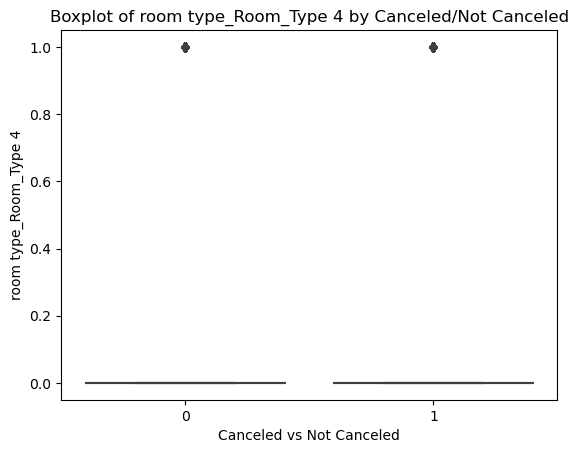

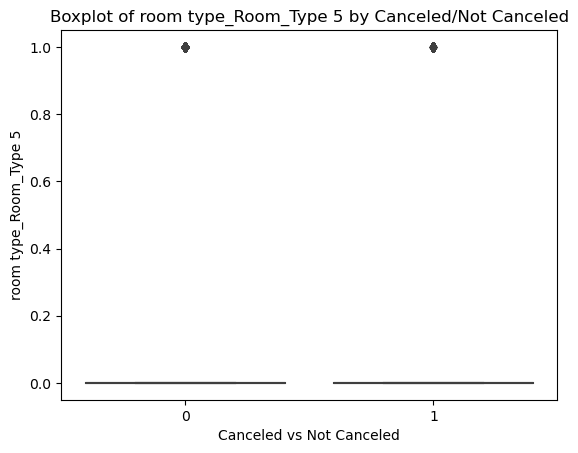

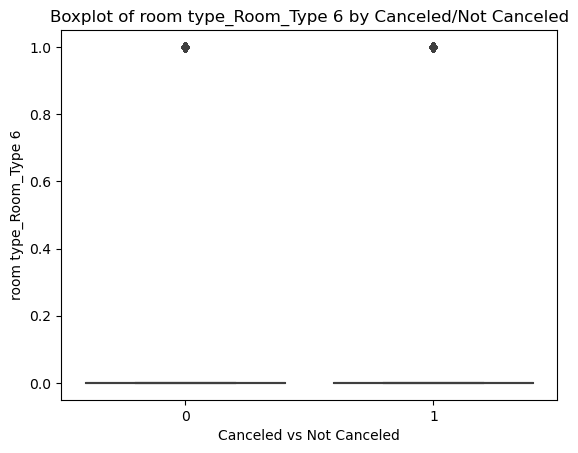

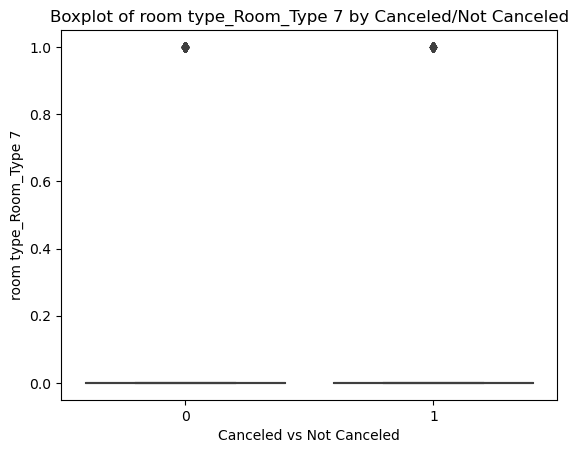

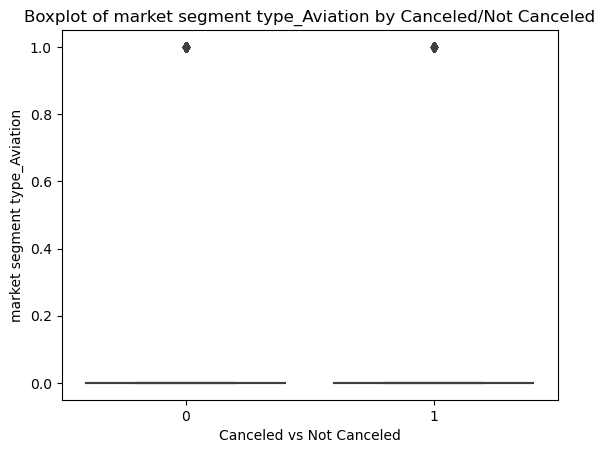

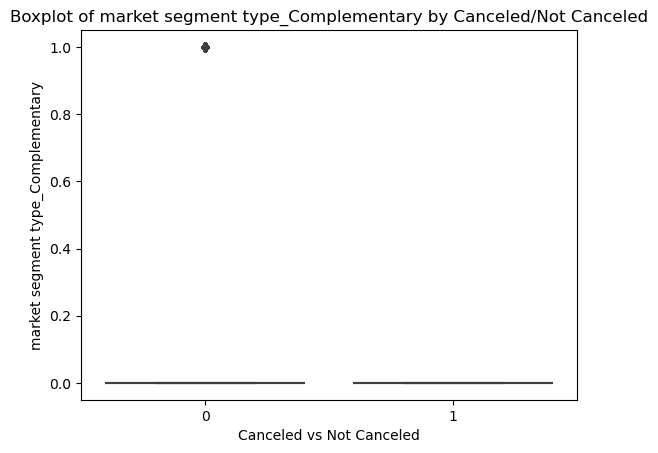

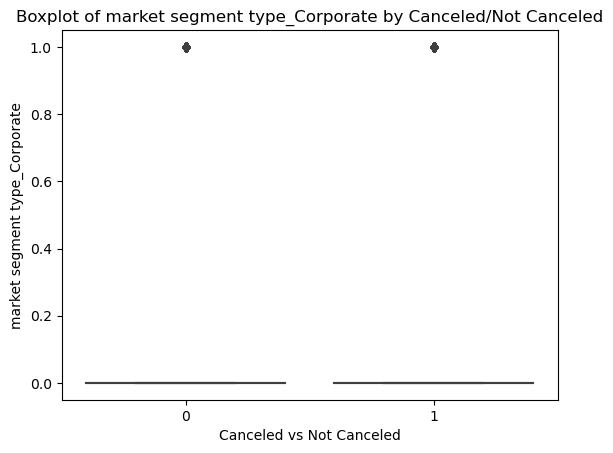

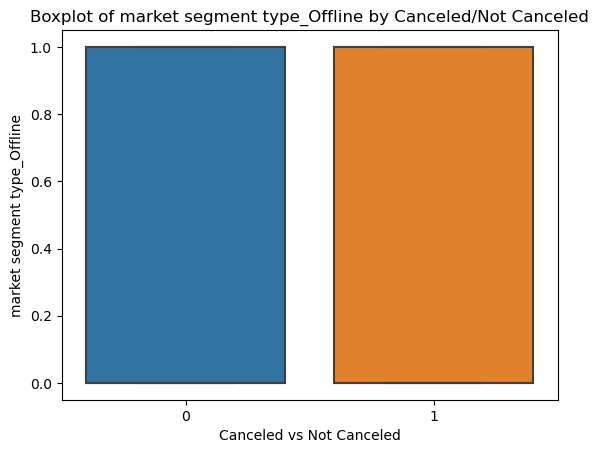

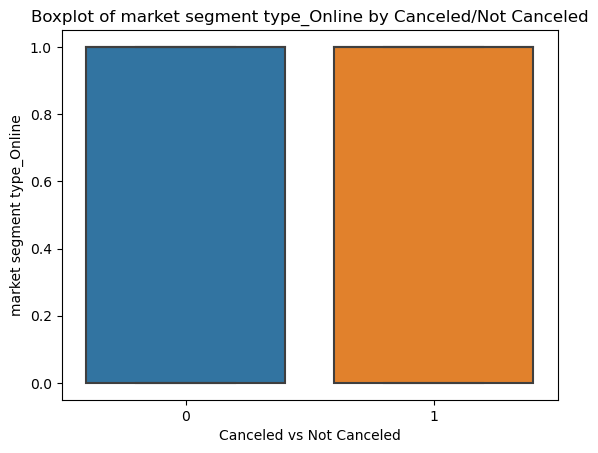

In [75]:
for i in variables:
  sns.boxplot(x='Canceled', y=i, data=data)
  plt.title(f"Boxplot of {i} by Canceled/Not Canceled")
  plt.xlabel("Canceled vs Not Canceled")
  plt.ylabel(f"{i}")
  plt.show()

# Possible Models

In [76]:
# function to evalue model performance (train vs test)
def model_performance(model, X_test, y_test):
  predictions = model.predict(X_test)
  mse = mean_squared_error(y_test, predictions)
  accuracy = accuracy_score(y_test, predictions)
  cm = confusion_matrix(y_test, predictions)
  print(f"This model, using {model}, has an mse of {mse}. \n The accuracy is {round(accuracy*100,2)}%.\n")
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
  plt.xlabel('Predicted Label:')
  plt.ylabel('True Label:')
  plt.show

## Logistic Regression

This model, using LogisticRegression(multi_class='ovr', solver='liblinear'), has an mse of 0.20201185062698085. 
 The accuracy is 79.8%.



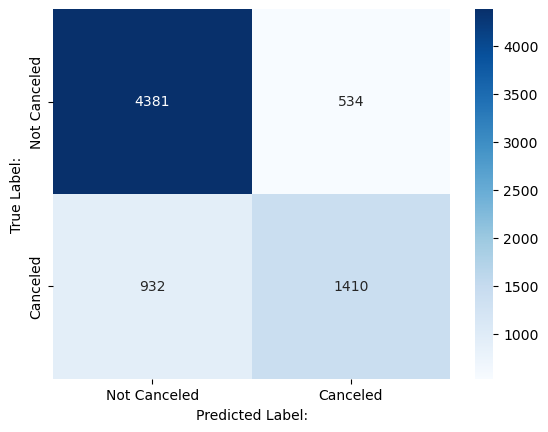

In [77]:
logistic_regression = LogisticRegression(solver='liblinear', multi_class='ovr')
logistic_regression.fit(X_train, y_train)
model_performance(logistic_regression, X_test, y_test)

## Lasso Logistic Regression

This model, using LogisticRegressionCV(cv=5, penalty='l1', random_state=211, solver='liblinear'), has an mse of 0.20159845666253273. 
 The accuracy is 79.84%.



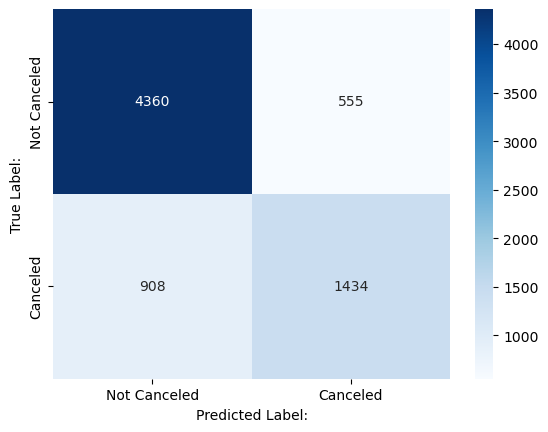

In [78]:
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.fit_transform(X_test)

lasso_logistic_regression_cv = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5, random_state=211)
lasso_logistic_regression_cv.fit(X_train2, y_train)
model_performance(lasso_logistic_regression_cv, X_test2, y_test)

# also print which parameters are nonzero for Lasso + with names and explanation

## Ridge Logistic Regression

This model, using LogisticRegressionCV(cv=5, random_state=211, solver='liblinear'), has an mse of 0.20118506269808462. 
 The accuracy is 79.88%.



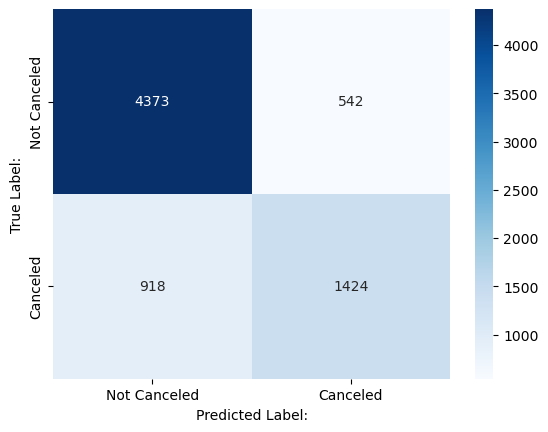

In [79]:
ridge_logistic_regression_cv = LogisticRegressionCV(solver='liblinear', cv=5, random_state=211)
ridge_logistic_regression_cv.fit(X_train2, y_train)
model_performance(ridge_logistic_regression_cv, X_test2, y_test)

# also print which parameters are nonzero for Ridge + with names and explanation

## Elastic Net Logistic Regression

/Users/yujin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yujin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yujin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yujin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yujin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yujin/anaconda3/lib/python3.11/site-packages/sklearn/linea

This model, using LogisticRegressionCV(cv=5, l1_ratios=[0.1, 0.5, 0.9], penalty='elasticnet',
                     random_state=211, solver='saga'), has an mse of 0.2022874466032796. 
 The accuracy is 79.77%.



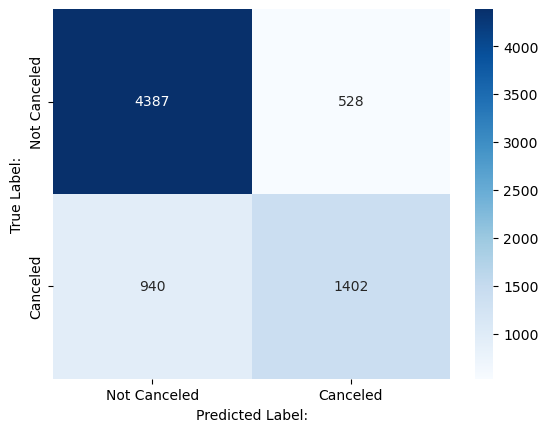

In [80]:
elastic_net_logistic_regression = LogisticRegressionCV(penalty = 'elasticnet', solver='saga', l1_ratios=[0.1,0.5,0.9], cv=5, random_state=211)
elastic_net_logistic_regression.fit(X_train2, y_train)
model_performance(elastic_net_logistic_regression, X_test2, y_test)

# also print which parameters are nonzero for EN + with names and explanation

## Principal Component - Logistic Regression

[1.22789151e-01 9.22594205e-02 7.96129335e-02 6.44915143e-02
 5.68299455e-02 4.83025500e-02 4.77196799e-02 4.24167256e-02
 3.98067239e-02 3.81050908e-02 3.71176425e-02 3.63412500e-02
 3.56161498e-02 3.28278395e-02 3.20169629e-02 3.13663770e-02
 3.02526091e-02 2.64345194e-02 2.49775562e-02 2.21990862e-02
 1.76751783e-02 1.57111311e-02 1.33500569e-02 1.17799061e-02
 1.03457183e-29 9.70872069e-31 8.23324082e-31]
Based on this plot, we will run a PCA logistic regression with 5 components.
This model, using LogisticRegression(), has an mse of 0.2691194708557255. 
 The accuracy is 73.09%.

This model clearly overestimates predictions - it is classifying cancellations pretty accurately, but it is not classifying non-cancellations well.


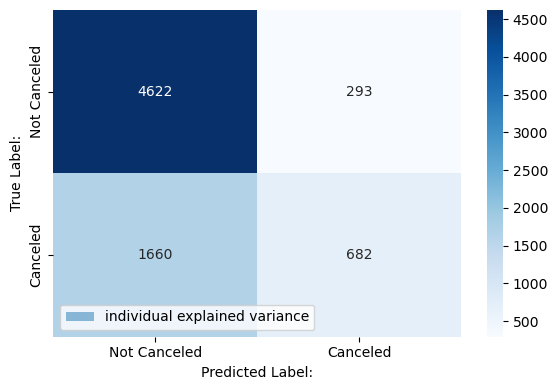

In [81]:
# for PCA we will use scaled data
pca = PCA()
X_train_pca = pca.fit_transform(X_train2)
X_test_pca = pca.transform(X_test2)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

plt.figure(figsize=(6, 4))

plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center',
        label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

print("Based on this plot, we will run a PCA logistic regression with 5 components.")

PCA_5 = LogisticRegression()
PCA_5.fit(X_train_pca[:,:5], y_train)
model_performance(PCA_5, X_test_pca[:,:5], y_test)

print("This model clearly overestimates predictions - it is classifying cancellations pretty accurately, but it is not classifying non-cancellations well.")

## K Nearest Neighbors

## One Decision Tree (CART)

This model, using DecisionTreeClassifier(random_state=122), has an mse of 0.1409673418768086. 
 The accuracy is 85.9%.



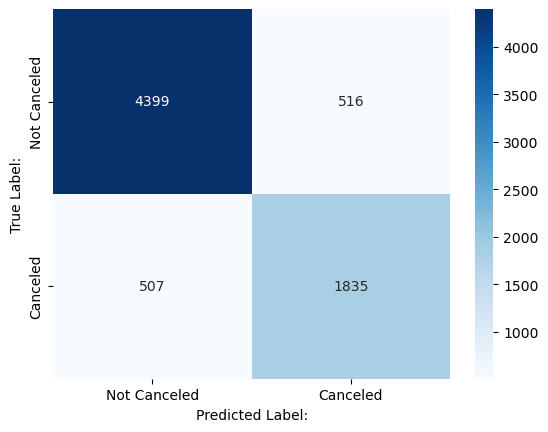

In [82]:
cart_model = DecisionTreeClassifier(random_state=122)
cart_model.fit(X_train, y_train)
model_performance(cart_model, X_test, y_test)

# visualize tree still to do

## Random Forest

This model, using RandomForestClassifier(n_estimators=500, oob_score=True, random_state=122), has an mse of 0.11161637040099215. 
 The accuracy is 88.84%.



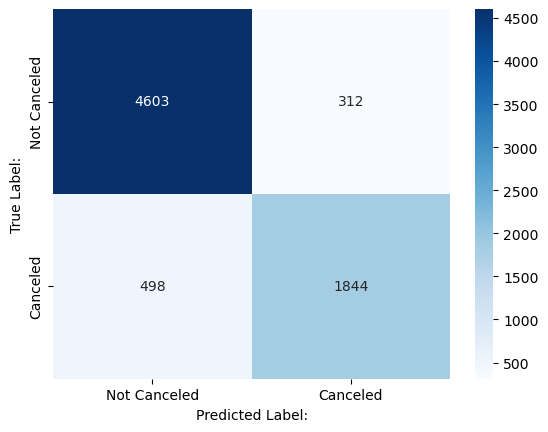

In [83]:
rf_model = RandomForestClassifier(n_estimators=500, random_state = 122, oob_score=True)
rf_model.fit(X_train, y_train)
model_performance(rf_model, X_test, y_test)

# Random Forest Deep Dive

Since our Random Forest model outperforms all other models considered, we will use this model to determine what features are important / drive cancellation for hotel bookings.

In [84]:
# mean decrease in impurity
mean_decrease_impurity = rf_model.feature_importances_

for i, importance in enumerate(mean_decrease_impurity):
    print(f"{i} mean decrease in impurity: {importance}")

print("MDI counts the times a feature is used to split a node, weight by the number of samples it splits. This measure showcases how important a feature is for the splits in the trees.")

# permutation feature importance
output = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=122)

for i, importance in enumerate(output.importances_mean):
    print(f"{[i]} permutation: {importance}")
print("permutation feature calculation includes an intermediate calculation of the out of sample model prediction accuracy. Then, the values for the variable are randomly permutated (hence the name) and the accuracy is calculated again. If accuracy decreases, this means that the variable is important in the random forest.")

0 mean decrease in impurity: 0.02626728604633731
1 mean decrease in impurity: 0.007883833142177646
2 mean decrease in impurity: 0.04321228145165867
3 mean decrease in impurity: 0.06478982792741085
4 mean decrease in impurity: 0.00707040766781971
5 mean decrease in impurity: 0.41220577073148
6 mean decrease in impurity: 0.0022216336063196934
7 mean decrease in impurity: 0.00046406717876284174
8 mean decrease in impurity: 0.001938743087905405
9 mean decrease in impurity: 0.24013614077162668
10 mean decrease in impurity: 0.10795764792997409
11 mean decrease in impurity: 0.0065595226809230635
12 mean decrease in impurity: 0.0076374147782570356
13 mean decrease in impurity: 4.5123213657178485e-05
14 mean decrease in impurity: 0.004870519741854332
15 mean decrease in impurity: 0.0059204858520448345
16 mean decrease in impurity: 0.0020143903584015597
17 mean decrease in impurity: 4.755715276873998e-05
18 mean decrease in impurity: 0.005471616303259407
19 mean decrease in impurity: 0.001654991

Feature Importance by Mean Decrease Impurity:


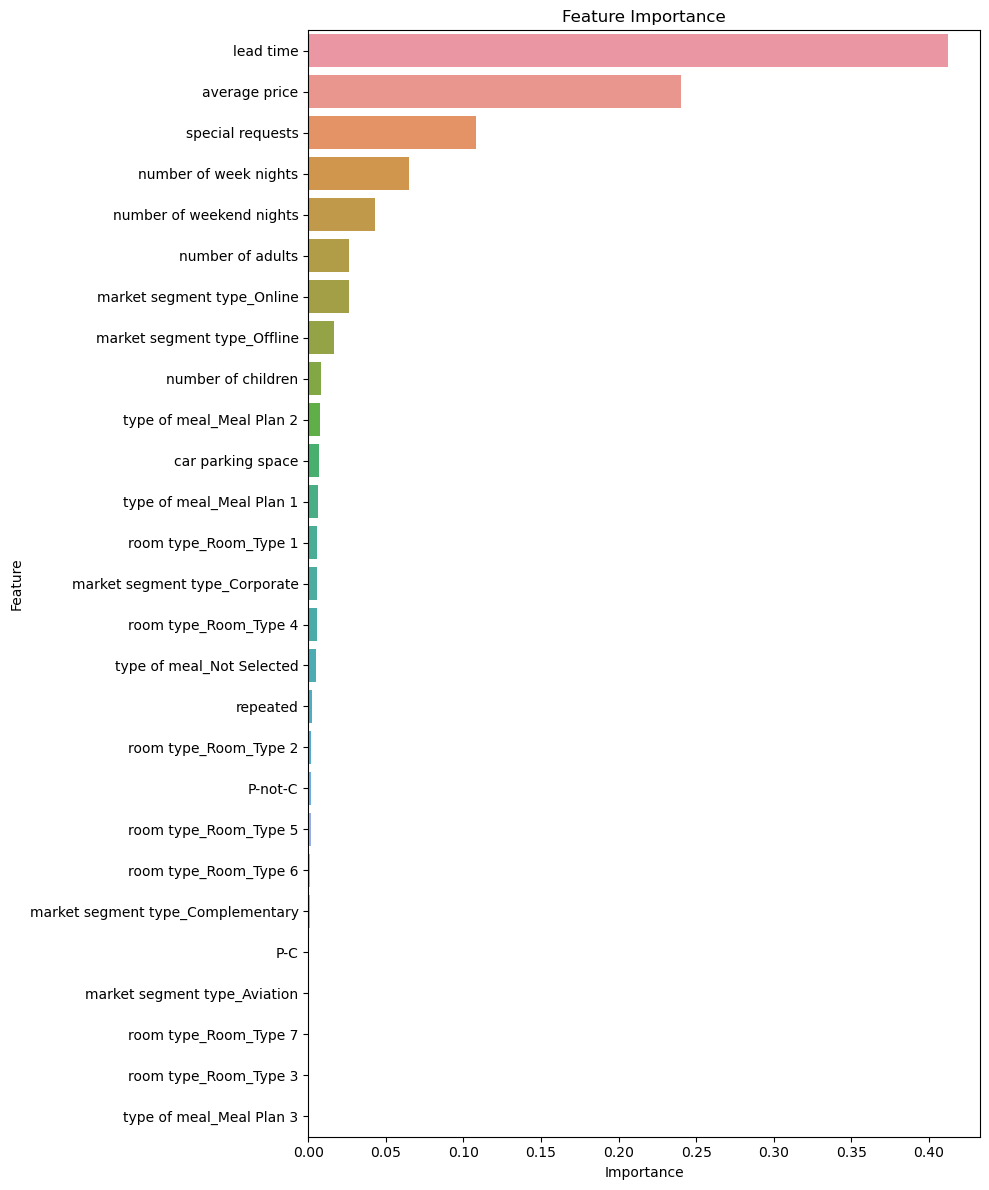

Feature Importance by Permutation Feature Calculation:


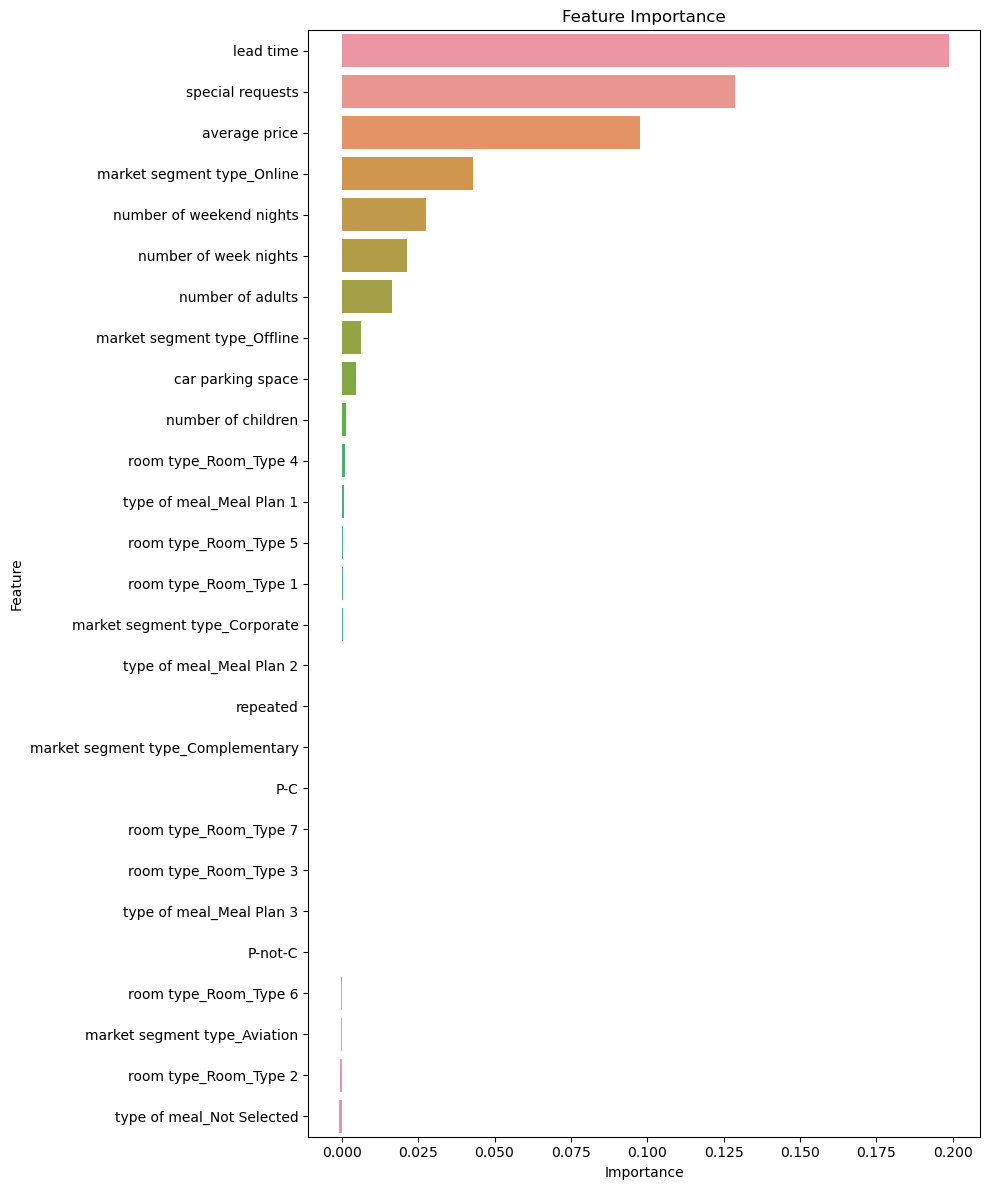

In [85]:
# code from Icey
mdi_dataframe = pd.DataFrame({'Feature': variables, 'Importance': mean_decrease_impurity})
permutation_dataframe = pd.DataFrame({'Feature': variables, 'Importance': output.importances_mean})

def PlotFeatureImportance(importance_df):
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 12))
    sns.barplot(x='Importance', y='Feature',  data=importance_df, orient='h')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

print("Feature Importance by Mean Decrease Impurity:")
PlotFeatureImportance(mdi_dataframe)
print("Feature Importance by Permutation Feature Calculation:")
PlotFeatureImportance(permutation_dataframe)

In [86]:
# lily



from sklearn.preprocessing import StandardScaler
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

from xgboost import XGBClassifier


# Scaling features (optional but recommended for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

random_state = 2
# Re-initialize classifiers with a higher max_iter for Logistic Regression
classifiers = [
    SVC(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1),
    RandomForestClassifier(random_state=random_state),
    XGBClassifier(random_state=random_state),
    KNeighborsClassifier(),
    LogisticRegression(random_state=random_state, max_iter=1000)  # Increased max_iter
]

# Initialize DataFrame for storing results
data = pd.DataFrame({
    "Classifier": ["SVC", "Decision Tree", "AdaBoost", "Random Forest", "XGB", "KNN", "Logistic Regression"],
    "TrainAccuracy": np.nan,
    "TestAccuracy": np.nan
})

# Evaluate classifiers
for i, classifier in enumerate(classifiers):
    # Fit and predict using scaled data for algorithms sensitive to feature scaling
    if classifier in [LogisticRegression, SVC, KNeighborsClassifier]:
        classifier.fit(X_train_scaled, y_train)
        train_preds = classifier.predict(X_train_scaled)
        test_preds = classifier.predict(X_test_scaled)
    else:
        classifier.fit(X_train, y_train)
        train_preds = classifier.predict(X_train)
        test_preds = classifier.predict(X_test)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)

    # Store in DataFrame
    data.loc[i, "TrainAccuracy"] = train_accuracy
    data.loc[i, "TestAccuracy"] = test_accuracy

print(data)



            Classifier  TrainAccuracy  TestAccuracy
0                  SVC       0.768672      0.775114
1        Decision Tree       0.992042      0.859722
2             AdaBoost       0.992042      0.859308
3        Random Forest       0.992008      0.889210
4                  XGB       0.903714      0.881494
5                  KNN       0.874466      0.813559
6  Logistic Regression       0.800951      0.798126


/Users/yujin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [87]:
#partial lasso

import numpy as np
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Example dataset for demonstration purposes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

class SelectiveRegularizationLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, penalty_weights, tol=1e-4, max_iter=100):
        self.penalty_weights = penalty_weights
        self.tol = tol
        self.max_iter = max_iter

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _loss(self, coef, X, y):
        predictions = self._sigmoid(X @ coef)
        basic_loss = log_loss(y, predictions)
        # Apply regularization to all coefficients except the intercept
        reg_term = sum(self.penalty_weights * abs(coef[1:]))  # Skip intercept
        return basic_loss + reg_term

    def fit(self, X, y):
        X = np.hstack([np.ones((X.shape[0], 1)), X])  # Add intercept term
        initial_coef = np.zeros(X.shape[1])
        result = minimize(self._loss, initial_coef, args=(X, y), method='SLSQP', tol=self.tol, options={'maxiter': self.max_iter})
        self.coef_ = result.x
        return self

    def predict_proba(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])  # Add intercept term
        proba = self._sigmoid(X @ self.coef_)
        return np.vstack([1-proba, proba]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

# Define a range of penalty weights to explore
penalty_weight_options = np.linspace(0.01, 1.0, 10)

best_score = np.inf
best_weight = None

# Iterating over penalty weight options
for penalty_weight in penalty_weight_options:
    # Apply the same penalty weight to all non-intercept coefficients
    penalty_weights = penalty_weight

    model = SelectiveRegularizationLogisticRegression(penalty_weights=penalty_weights)
    model.fit(X_train, y_train)

    val_predictions = model.predict_proba(X_test)
    score = log_loss(y_test, val_predictions)

    if score < best_score:
        best_score = score
        best_weight = penalty_weight

print(f"Best penalty weight: {best_weight}")

# Train final model with best penalty weight
final_model = SelectiveRegularizationLogisticRegression(penalty_weights=best_weight)
final_model.fit(X_train, y_train)








/var/folders/yc/rcdm0kxs3cn_sh64ml52d_tc0000gn/T/ipykernel_88942/1444185738.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/yc/rcdm0kxs3cn_sh64ml52d_tc0000gn/T/ipykernel_88942/1444185738.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/yc/rcdm0kxs3cn_sh64ml52d_tc0000gn/T/ipykernel_88942/1444185738.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/yc/rcdm0kxs3cn_sh64ml52d_tc0000gn/T/ipykernel_88942/1444185738.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/yc/rcdm0kxs3cn_sh64ml52d_tc0000gn/T/ipykernel_88942/1444185738.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/yc/rcdm0kxs3cn_sh64ml52d_tc0000gn/T/ipykernel_88942/1444185738.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/yc/rcdm0kxs3cn_sh64ml52d_tc0000gn/T/ipykernel

Best penalty weight: 0.01


/var/folders/yc/rcdm0kxs3cn_sh64ml52d_tc0000gn/T/ipykernel_88942/1444185738.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/yc/rcdm0kxs3cn_sh64ml52d_tc0000gn/T/ipykernel_88942/1444185738.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/yc/rcdm0kxs3cn_sh64ml52d_tc0000gn/T/ipykernel_88942/1444185738.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/yc/rcdm0kxs3cn_sh64ml52d_tc0000gn/T/ipykernel_88942/1444185738.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/yc/rcdm0kxs3cn_sh64ml52d_tc0000gn/T/ipykernel_88942/1444185738.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/yc/rcdm0kxs3cn_sh64ml52d_tc0000gn/T/ipykernel_88942/1444185738.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/var/folders/yc/rcdm0kxs3cn_sh64ml52d_tc0000gn/T/ipykernel

SelectiveRegularizationLogisticRegression(penalty_weights=0.01)

In [88]:
from sklearn.metrics import accuracy_score

# Making predictions on the test set
y_pred = final_model.predict(X_test)

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.7957451499118166


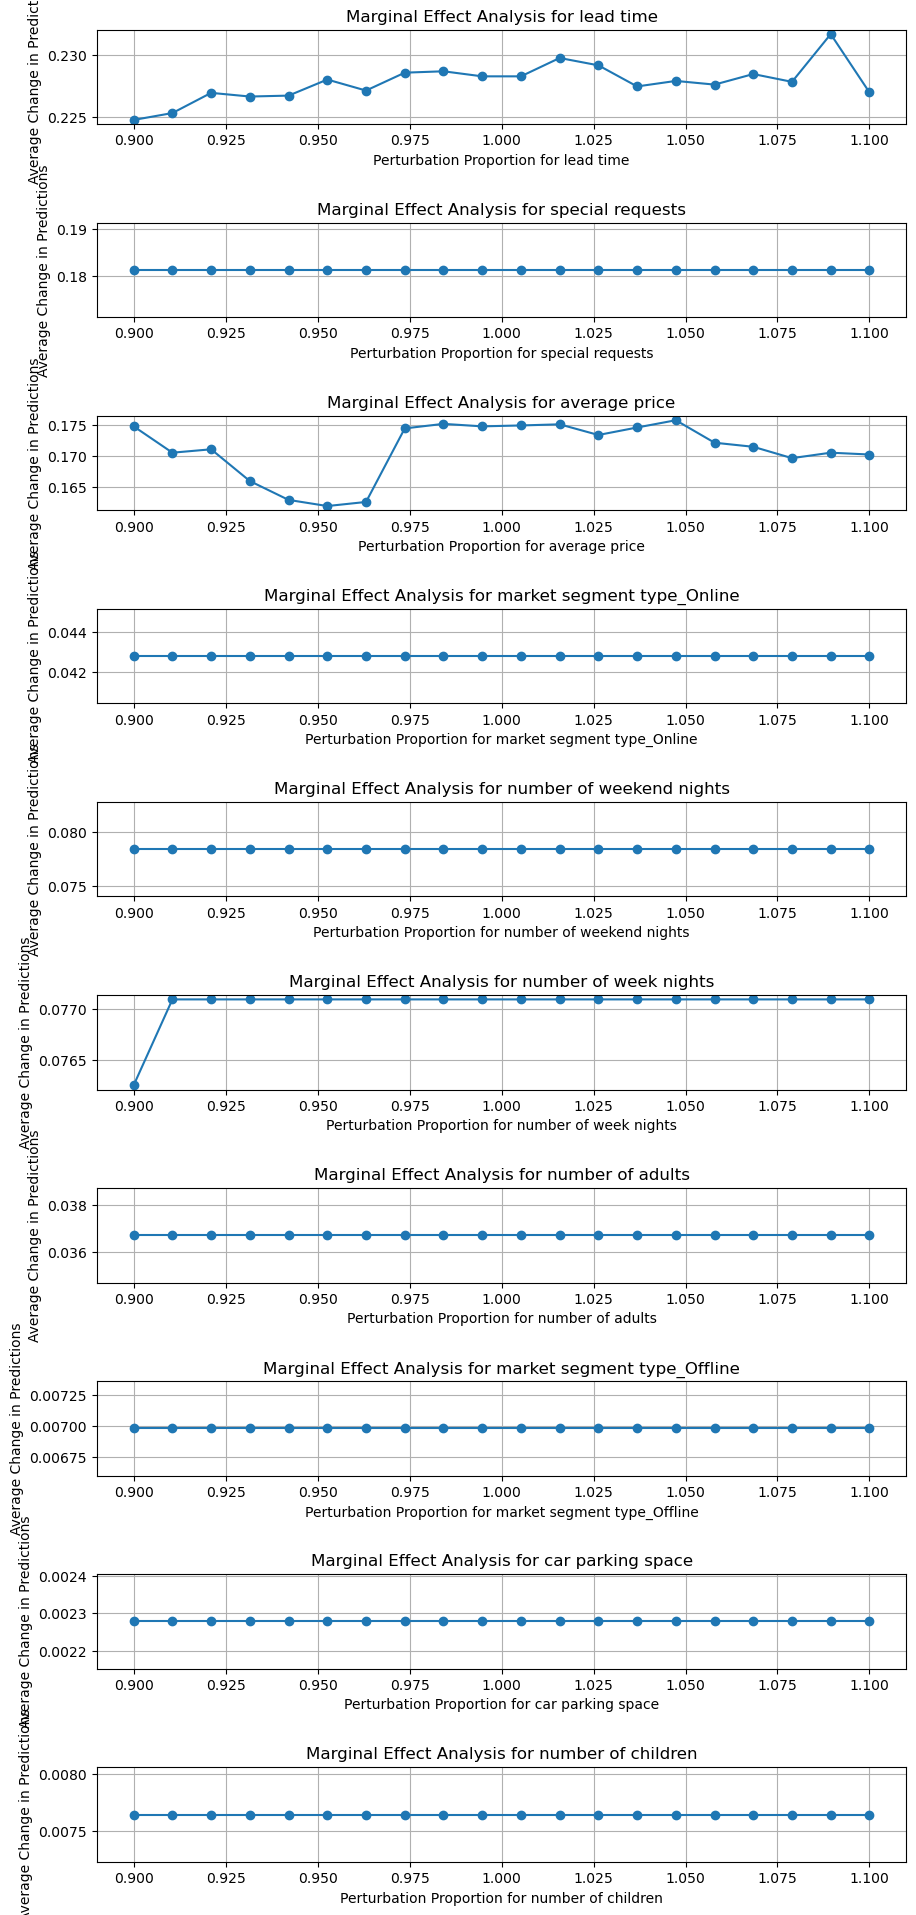

In [107]:
## perturbation analysis 

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt



# Initialize and fit the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=122, oob_score=True)
rf_model.fit(X_train, y_train)

def perturb_and_evaluate(model, features, target, variables_to_perturb):
    baseline_preds = model.predict(features)
    baseline_mse = mean_squared_error(target, baseline_preds)
    
    perturbation_results = {}
    marginal_effects = {}

    for variable in variables_to_perturb:
        perturbed_mse_values = []
        marginal_effect_values = []
        original_values = features[variable].copy()
        mean_value = original_values.mean()
        
        perturbations = mean_value * np.linspace(0.9, 1.1, 20)
        
        for perturb_value in perturbations:
            perturbed_features = features.copy()
            perturbed_features[variable] = perturb_value
            
            perturbed_preds = model.predict(perturbed_features)
            perturbed_mse = mean_squared_error(target, perturbed_preds)
            marginal_effect = np.mean(perturbed_preds != baseline_preds)
            
            perturbed_mse_values.append(perturbed_mse)
            marginal_effect_values.append(marginal_effect)
        
        perturbation_results[variable] = perturbed_mse_values
        marginal_effects[variable] = marginal_effect_values

    return perturbation_results, marginal_effects

# Specify the variables you want to perturb
variables_to_perturb = [    'lead time', 'special requests', 'average price',
    'market segment type_Online', 'number of weekend nights',
    'number of week nights', 'number of adults',
    'market segment type_Offline', 'car parking space',
    'number of children']  

# Call the perturb_and_evaluate function with the correct arguments
perturbation_results, marginal_effects = perturb_and_evaluate(rf_model, X_train, y_train, variables_to_perturb)

# Assuming perturbation_results and marginal_effects have already been calculated
fig, axs = plt.subplots(len(variables_to_perturb), figsize=(10, 20))
fig.tight_layout(pad=5.0)

# Plot marginal effects for each variable
for idx, variable in enumerate(variables_to_perturb):
    axs[idx].plot(np.linspace(0.9, 1.1, 20), marginal_effects[variable], marker='o')
    axs[idx].set_xlabel(f'Perturbation Proportion for {variable}')
    axs[idx].set_ylabel('Average Change in Predictions')
    axs[idx].set_title(f'Marginal Effect Analysis for {variable}')
    axs[idx].grid(True)

plt.show()

            





<Figure size 1000x800 with 0 Axes>

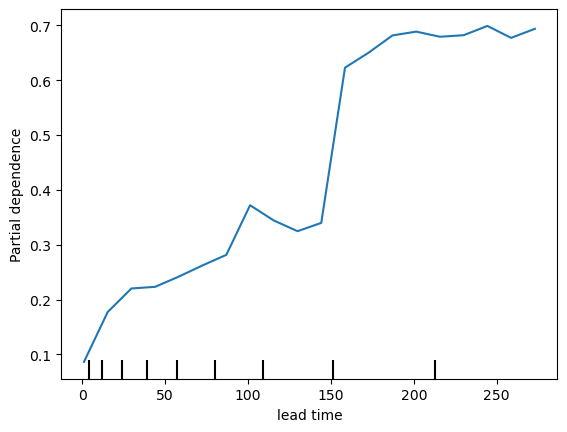

<Figure size 1000x800 with 0 Axes>

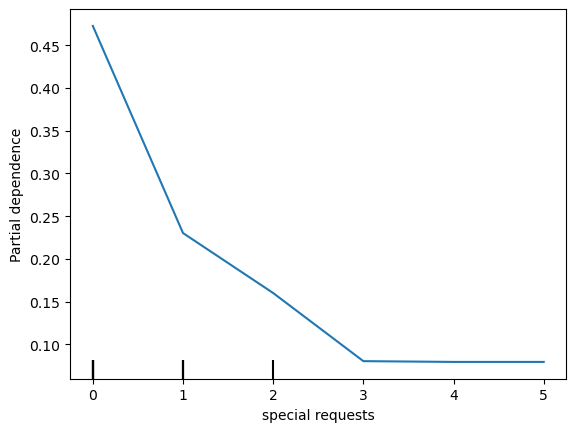

<Figure size 1000x800 with 0 Axes>

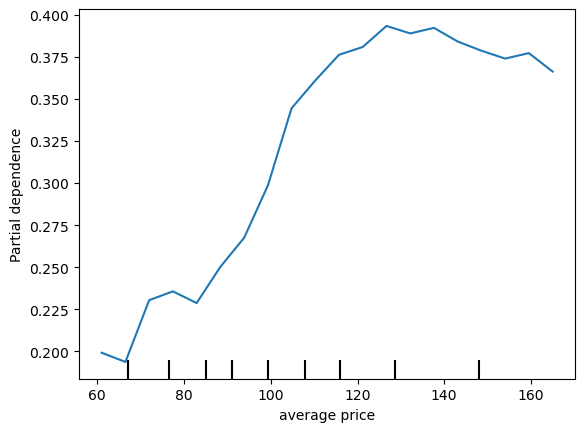

<Figure size 1000x800 with 0 Axes>

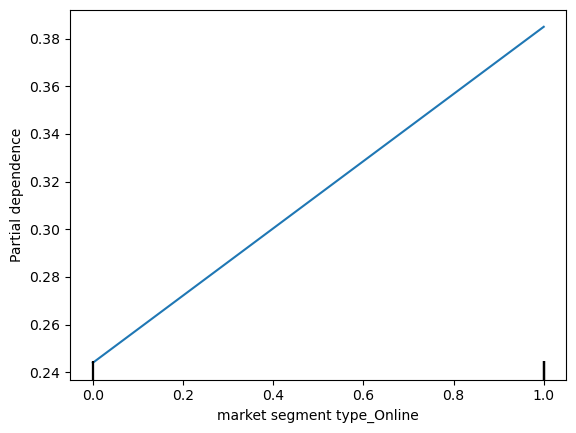

<Figure size 1000x800 with 0 Axes>

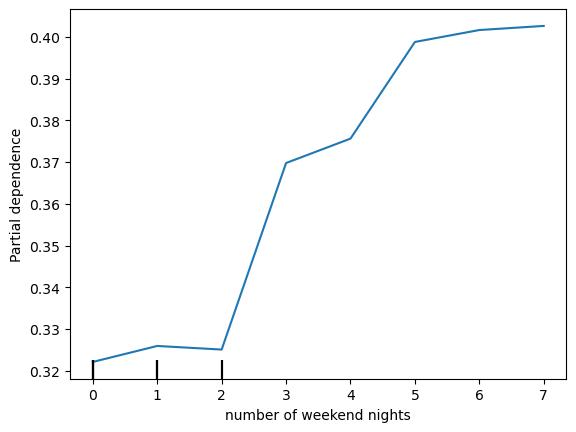

<Figure size 1000x800 with 0 Axes>

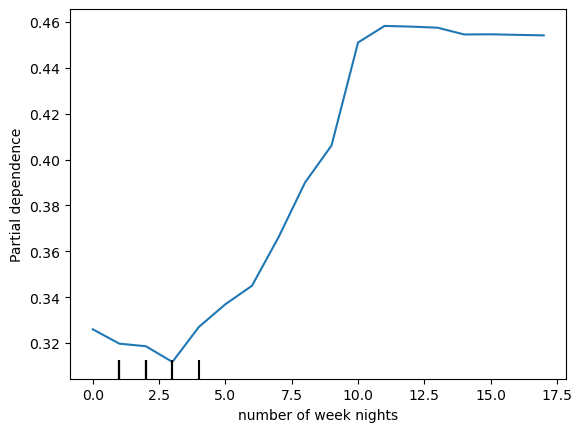

<Figure size 1000x800 with 0 Axes>

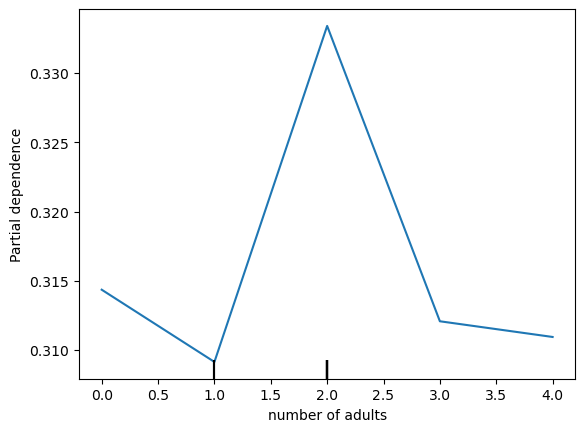

<Figure size 1000x800 with 0 Axes>

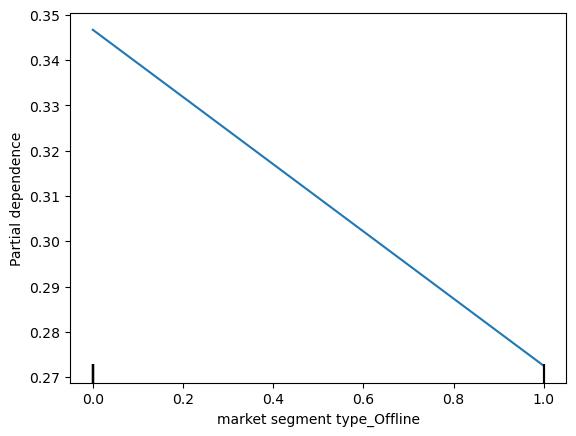

<Figure size 1000x800 with 0 Axes>

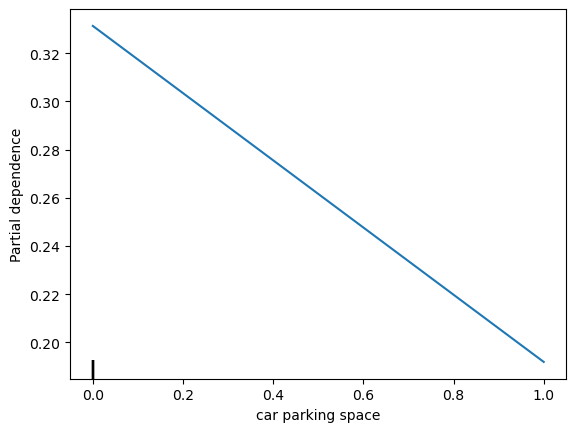

<Figure size 1000x800 with 0 Axes>

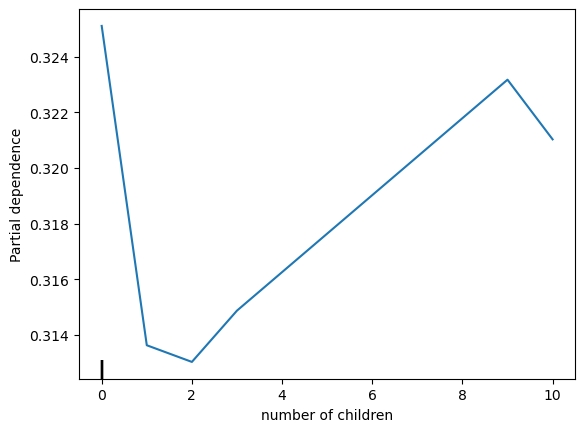

In [101]:

# furthermore use partial dependence plots to determine the relationships
from sklearn.inspection import PartialDependenceDisplay
dep_var = [
    'lead time', 'special requests', 'average price',
    'market segment type_Online', 'number of weekend nights',
    'number of week nights', 'number of adults',
    'market segment type_Offline', 'car parking space',
    'number of children'
]

for feature in dep_var:
  plt.figure(figsize=(10,8))
  PartialDependenceDisplay.from_estimator(rf_model, X_train, features=[feature], kind="average", grid_resolution=20)
  plt.show()